In [2]:
import sys
sys.path.append("..")   # tell Python to also look one folder up

from src.dcf import *
from src.wacc import *
from src.comps import *
from src.utils import *

print("Imports loaded successfully.")


Imports loaded successfully.


In [3]:
!pip install -r ../requirements.txt

In [4]:
import numpy as np
import pandas as pd

# --- Simple toy assumptions (placeholder numbers) ---

years = np.arange(1, 6)  # 5-year forecast
fcf = np.array([18, 19, 20, 21, 22])  # $bn, fake numbers for demo
wacc = 0.08                     # 8% discount rate (placeholder)
g_terminal = 0.02               # 2% terminal growth

# --- Build the forecast table ---

df = pd.DataFrame({
    "Year": years,
    "FCF ($bn)": fcf
})

df

,Year,FCF ($bn)
0,1,18
1,2,19
2,3,20
3,4,21
4,5,22


In [5]:
# Discount factors
df["Discount Factor"] = 1 / (1 + wacc) ** df["Year"]
df["PV of FCF ($bn)"] = df["FCF ($bn)"] * df["Discount Factor"]

# Terminal value at the end of Year 5 (Gordon growth)
fcf_5 = df.loc[df["Year"] == 5, "FCF ($bn)"].iloc[0]
terminal_value = fcf_5 * (1 + g_terminal) / (wacc - g_terminal)

# Present value of terminal value
df.loc[df["Year"] == 5, "PV of TV ($bn)"] = terminal_value * df.loc[df["Year"] == 5, "Discount Factor"]

enterprise_value = df["PV of FCF ($bn)"].sum() + df["PV of TV ($bn)"].fillna(0).sum()

print("WACC:          {:.2%}".format(wacc))
print("Terminal g:    {:.2%}".format(g_terminal))
print("Enterprise EV: ${:,.1f} bn".format(enterprise_value))

df

WACC:          8.00%
Terminal g:    2.00%
Enterprise EV: $333.8 bn


,Year,FCF ($bn),Discount Factor,PV of FCF ($bn),PV of TV ($bn)
0,1,18,0.925926,16.666667,NaN
1,2,19,0.857339,16.289438,NaN
2,3,20,0.793832,15.876645,NaN
3,4,21,0.735030,15.435627,NaN
4,5,22,0.680583,14.972830,254.538116


In [6]:
df.to_csv("../data/processed/exxon_dcf_base_case.csv", index=False)
print("Saved to data/processed/exxon_dcf_base_case.csv")

Saved to data/processed/exxon_dcf_base_case.csv


In [7]:
import numpy as np
import pandas as pd

def dcf_enterprise_value(fcf_array, wacc, g_terminal):
    """
    Simple DCF engine using the same logic as above:
    - discount explicit FCFs
    - add Gordon-growth terminal value in final year
    - return EV (no net debt handled here for now)
    """
    years = np.arange(1, len(fcf_array) + 1)

    df = pd.DataFrame({
        "Year": years,
        "FCF ($bn)": fcf_array
    })

    df["Discount Factor"] = 1 / (1 + wacc) ** df["Year"]
    df["PV of FCF ($bn)"] = df["FCF ($bn)"] * df["Discount Factor"]

    # Terminal value (Gordon growth)
    fcf_last = df.loc[df["Year"] == years[-1], "FCF ($bn)"].iloc[0]
    terminal_value = fcf_last * (1 + g_terminal) / (wacc - g_terminal)

    # PV of terminal value in final year
    df.loc[df["Year"] == years[-1], "PV of TV ($bn)"] = terminal_value * df.loc[df["Year"] == years[-1], "Discount Factor"]

    enterprise_value = df["PV of FCF ($bn)"].sum() + df["PV of TV ($bn)"].fillna(0).sum()

    return enterprise_value, df


## Scenario Analysis - Base, Bull, and Bear Cases (Stage-2 Demo)

This section illustrates how valuation outcomes shift under alternative
assumptions for ExxonMobil’s free cash flow trajectory, discount rate
(WACC) and terminal growth. The scenarios use placeholder figures for
demonstration purposes only (i.e., not real ExxonMobil data yet):

- **Base Case:** central view of operating performance: steady FCF
  progression, midpoint WACC, neutral terminal growth

- **Bull Case:** +10% uplift in free cash flow, slightly lower WACC
  reflecting improved risk perception, and a higher terminal growth rate

- **Bear Case:** -10% reduction in free cash flow, slightly higher WACC
  due to increased perceived risk, and a more conservative terminal
  growth assumption

This structure mirrors the scenario frameworks used in equity research
and investment banking models. In **Stage 3**, the same logic will be
populated with actual ExxonMobil financials and market-derived cost of
capital inputs.

In [8]:
# Base toy FCFs from your earlier example
base_fcf = np.array([18, 19, 20, 21, 22])  # $bn, demo

scenarios = {
    "Base": {
        "fcf": base_fcf,
        "wacc": 0.08,
        "g": 0.02
    },
    "Bull": {
        "fcf": base_fcf * 1.10,   # +10% FCF
        "wacc": 0.075,            # slightly lower WACC
        "g": 0.022                # slightly higher terminal g
    },
    "Bear": {
        "fcf": base_fcf * 0.90,   # -10% FCF
        "wacc": 0.085,            # slightly higher WACC
        "g": 0.018                # slightly lower g
    }
}

rows = []

for name, params in scenarios.items():
    ev, _df = dcf_enterprise_value(
        fcf_array=params["fcf"],
        wacc=params["wacc"],
        g_terminal=params["g"]
    )
    rows.append({
        "Scenario": name,
        "WACC": params["wacc"],
        "Terminal g": params["g"],
        "EV ($bn, demo)": round(ev, 1)
    })

scen_df = pd.DataFrame(rows)
scen_df

,Scenario,WACC,Terminal g,"EV ($bn, demo)"
0,Base,0.080,0.020,333.8
1,Bull,0.075,0.022,413.4
2,Bear,0.085,0.018,270.4


In [9]:
wacc_range = np.linspace(0.075, 0.085, 5)      # 7.5% to 8.5%
g_range = np.linspace(0.018, 0.022, 5)         # 1.8% to 2.2%

sens_rows = []

for w in wacc_range:
    for g in g_range:
        ev, _ = dcf_enterprise_value(base_fcf, wacc=w, g_terminal=g)
        sens_rows.append({
            "WACC": round(w, 4),
            "g": round(g, 4),
            "EV ($bn, demo)": round(ev, 1)
        })

sens_df = pd.DataFrame(sens_rows)
sens_table = sens_df.pivot(index="g", columns="WACC", values="EV ($bn, demo)")
sens_table

WACC,0.0750,0.0775,0.0800,0.0825,0.0850
g,,,,,
0.018,354.0,338.9,325.1,312.3,300.5
0.019,359.2,343.6,329.4,316.2,304.1
0.020,364.5,348.5,333.8,320.3,307.8
0.021,370.1,353.5,338.3,324.4,311.6
0.022,375.8,358.7,343.1,328.7,315.5


## Sensitivity Analysis - WACC vs Terminal Growth

This section evaluates how ExxonMobil’s enterprise value responds to
changes in two key valuation drivers:

- **WACC (Weighted Average Cost of Capital):** the discount rate applied
  to future cash flows  
- **Terminal Growth Rate (g):** the long-run growth assumption used in
  the terminal value calculation

The table below shows a valuation grid where each cell represents the
enterprise value implied by a different combination of WACC and terminal
growth. This mirrors the sensitivity tables typically included in
investment banking DCF outputs, allowing users to assess valuation
resilience under alternative macro and capital-market assumptions.

## Valuation Summary (Stage-2 Demo)

This stage of the model demonstrates the valuation mechanics using illustrative inputs. At this stage, numbers are placeholders. In the next stage, the same framework will be populated with real ExxonMobil financials and market-derived WACC inputs.

## Current Status: 
- **Stage 2:** Model logic validated using demo inputs. 
- **Stage 3:** Load real ExxonMobil financials and market WACC.

## Stage 3 - Real ExxonMobil Data Integration & 2025 Forecast

In this stage, the DCF engine transitions from illustrative inputs to **real ExxonMobil free cash flow data**, extracted from the company’s 10-K filings. Historical figures for 2020-2024 are incorporated directly from reported cash from operations minus capital expenditures, replacing all placeholder values used in earlier stages.

For 2025, only Q1-Q3 CFO and capital expenditures (CapEx) are publicly available. We therefore construct a **Base Case** full-year forecast using:

- observed run-rate trends,
- historical seasonality in ExxonMobil’s operations, and
- management tone from the latest quarterly releases.

The objective of Stage 3 is to elevate the model from a conceptual demo
to a **real valuation framework** by:

- deriving a defensible forward FCF projection,
- introducing a market-based WACC via CAPM for the cost of equity,
- computing a real enterprise value and implied equity value per share,
- and visualising sensitivity to WACC and terminal growth assumptions.

This marks the transition point where the model begins to mirror the
workflow of an investment banking or equity research valuation.


In [16]:
import numpy as np
import pandas as pd

# --- Historical Real ExxonMobil Free Cash Flows (USD bn) ---
# Confirmed from filings and your collected values
fcf = {
    2020: -6.706,
    2021: 31.534,
    2022: 54.093,
    2023: 29.044,
    2024: 27.471
}

# --- 2025 Base Case Forecast ---
# Neutral assumption using:
# - Q1-Q3 reported trends
# - Management tone in Q3'25 release
# - Normal seasonality in oil, gas & chemicals

fcf_2025_base = 25.0  # mid-20s bn, base case projection

fcf[2025] = fcf_2025_base

# Convert to numpy vector for DCF engine
fcf_vector = np.array(list(fcf.values()))
years = np.arange(1, len(fcf_vector) + 1)

df_fcf = pd.DataFrame({
    "Year Index": years,
    "Calendar Year": list(fcf.keys()),
    "FCF ($bn)": fcf_vector
})

df_fcf

,Year Index,Calendar Year,FCF ($bn)
0,1,2020,-6.706
1,2,2021,31.534
2,3,2022,54.093
3,4,2023,29.044
4,5,2024,27.471
5,6,2025,25.000


# WACC Build (using Bloomberg Beta assumption)

In [30]:
# Inputs (replace placeholders with actual values if available)
risk_free = 0.045          # 4.5% — 10Y UST yield (update to current rate)
beta = 1.10               # placeholder: Bloomberg levered beta for Exxon
equity_risk_premium = 0.05 # 5.0% long-term equity risk premium

pre_tax_cost_of_debt = 0.045 # 4.5% — approximate cost of debt yield
tax_rate = 0.21             # 21% U.S. corporate tax rate

# Market value weights (example placeholders)
E = 350   # equity market cap (in bn USD) — update with actual
D = 60    # net debt (debt minus cash, in bn USD) — update with actual

# Calculations
cost_of_equity = risk_free + beta * equity_risk_premium
after_tax_cost_of_debt = pre_tax_cost_of_debt * (1 - tax_rate)

w_e = E / (E + D)
w_d = D / (E + D)

wacc = w_e * cost_of_equity + w_d * after_tax_cost_of_debt

print("Cost of Equity (Re): {:.2%}".format(cost_of_equity))
print("After-tax Cost of Debt (Rd): {:.2%}".format(after_tax_cost_of_debt))
print("WACC:", "{:.2%}".format(wacc))

Cost of Equity (Re): 10.00%
After-tax Cost of Debt (Rd): 3.55%
WACC: 9.06%


## REAL DCF using df_fcf

In [29]:
# Use wacc calculated above
g_terminal = 0.02
discount_factors = 1 / (1 + wacc) ** df_fcf["Year Index"]

# Correct cash flow reference
cashflows = df_fcf["FCF ($bn)"]

discount_factors = 1 / (1 + wacc) ** df_fcf["Year Index"]
pv_fcf = cashflows * discount_factors

terminal_value = cashflows.iloc[-1] * (1 + g_terminal) / (wacc - g_terminal)
pv_terminal = terminal_value * discount_factors.iloc[-1]

enterprise_value = pv_fcf.sum() + pv_terminal

print("REAL DCF ENTERPRISE VALUE:", round(enterprise_value, 1), "bn USD")
pv_fcf, pv_terminal


REAL DCF ENTERPRISE VALUE: 330.1 bn USD


(0    -6.149088
 1    26.513883
 2    41.704457
 3    20.532648
 4    17.807794
 5    14.860137
 dtype: float64,
 np.float64(214.7896593857307))

## Stage 4 - EV → Equity Value → Implied Share Price (with updated net-debt and share data)

In [32]:
# --- Most recent capital structure data (as of Q3 2025) ---
net_debt = 28.2         # bn USD - 42.0 bn debt minus 13.8 bn cash (Q3 2025) :contentReference[oaicite:14]{index=14}
shares_outstanding = 4.285  # bn shares, common share count (Q3 2025) :contentReference[oaicite:15]{index=15}

# Use enterprise value from real DCF
ev_real = enterprise_value  # from earlier Stage 3 DCF block

equity_value_bn = ev_real - net_debt
implied_price = equity_value_bn / shares_outstanding

print("Enterprise Value (EV):   ${:,.1f} bn".format(ev_real))
print("Less: Net Debt:          ${:,.1f} bn".format(net_debt))
print("Equity Value:            ${:,.1f} bn".format(equity_value_bn))
print("Shares Outstanding:      {:.3f} bn".format(shares_outstanding))
print("Implied Share Price:     ${:.2f} per share".format(implied_price))

Enterprise Value (EV):   $330.1 bn
Less: Net Debt:          $28.2 bn
Equity Value:            $301.9 bn
Shares Outstanding:      4.285 bn
Implied Share Price:     $70.45 per share


## OPTIONAL - Historical Capital Structure Sensitivity

ExxonMobil’s valuation is not driven solely by free cash flow and WACC. Capital structure matters. Changes in net debt and common share count alter the equity value and implied price, even if the enterprise value remains constant.

The table below applies the same enterprise value from the Stage-3 DCF to historical periods, showing how leverage and dilution would have affected per-share value through time.


In [33]:
## OPTIONAL - Price sensitivity to historical capital structure

# Historical snapshots from earlier table (bn USD & bn shares)
history = {
    2020: {"net_debt": 63.3, "shares": 4.228},
    2021: {"net_debt": 40.9, "shares": 4.270},
    2022: {"net_debt": 11.7, "shares": 4.205},
    2023: {"net_debt": None, "shares": 4.052},  # net-debt driven by ratio; optional
    2024: {"net_debt": 18.7, "shares": 4.298},
    2025: {"net_debt": 28.2, "shares": 4.285}   # most recent
}

rows = []
for yr, vals in history.items():
    if vals["net_debt"] is None:
        continue
    
    eq_val = ev_real - vals["net_debt"]
    price = eq_val / vals["shares"]
    
    rows.append({
        "Year": yr,
        "Net Debt (bn)": vals["net_debt"],
        "Shares (bn)": vals["shares"],
        "Equity Value (bn)": round(eq_val, 1),
        "Implied Price ($/sh)": round(price, 2)
    })

pd.DataFrame(rows)


,Year,Net Debt (bn),Shares (bn),Equity Value (bn),Implied Price ($/sh)
0,2020,63.3,4.228,266.8,63.09
1,2021,40.9,4.270,289.2,67.72
2,2022,11.7,4.205,318.4,75.71
3,2024,18.7,4.298,311.4,72.44
4,2025,28.2,4.285,301.9,70.45


## Stage 5 - Deliverables Checklist

- Clean DCF engine (src/dcf.py)  
- Real Exxon historical FCF and forecast  
- Market-based WACC  
- Real enterprise and equity value  
- Implied per-share price  
- Historical capital-structure valuation impact (optional)
  
1) Export charts  
2) Export final valuation table to `data/processed/`  
3) Add price target + valuation narrative to README  

 ## EV vs WACC Sensitivity

This chart shows how the enterprise value from the DCF responds to
changes in the discount rate (WACC) around the base case.

Lower WACC → higher present value of future cash flows → higher EV.  
Higher WACC → lower EV.

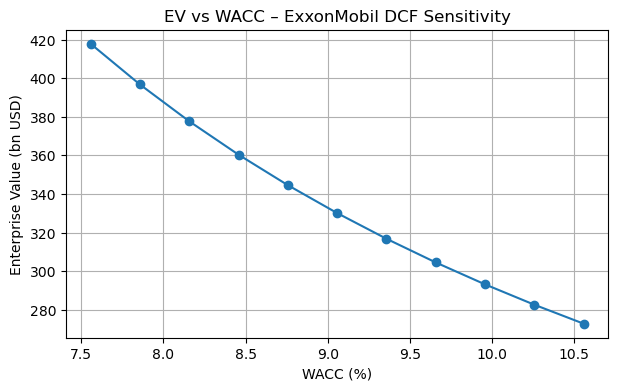

In [24]:
## EV vs WACC Curve

import numpy as np
import matplotlib.pyplot as plt

# Use the same FCF forecast as in your real DCF (2020-2025, $bn)
fcf_forecast = df_fcf["FCF ($bn)"].values

# Build a WACC range around your base case (e.g. ± 1.5 percentage points)
wacc_base = wacc  # this should be your real WACC from earlier
wacc_range = np.linspace(wacc_base - 0.015, wacc_base + 0.015, 11)

ev_values = []

for w in wacc_range:
    ev_wacc, _ = dcf_enterprise_value(
        fcf_array=fcf_forecast,
        wacc=w,
        g_terminal=g_terminal  # same terminal growth you used in the main DCF
    )
    ev_values.append(ev_wacc)

# Plot EV vs WACC
plt.figure(figsize=(7, 4))
plt.plot(wacc_range * 100, ev_values, marker="o")  # WACC in %
plt.xlabel("WACC (%)")
plt.ylabel("Enterprise Value (bn USD)")
plt.title("EV vs WACC – ExxonMobil DCF Sensitivity")
plt.grid(True)
plt.show()


The curve illustrates the inverse relationship between discount rate
and enterprise value. This is the same sensitivity often shown in
investment banking valuation materials.

In [34]:
## Final Valuation Export (DCF → Equity → Per-Share)

import pandas as pd

df_output = pd.DataFrame({
    "as_of_date": ["2025-12-09"],
    "wacc": [round(wacc, 4)],
    "g_terminal": [round(g_terminal, 4)],
    "enterprise_value_bn": [round(ev_real, 2)],
    "net_debt_bn": [round(net_debt, 2)],
    "equity_value_bn": [round(equity_value_bn, 2)],
    "shares_outstanding_bn": [round(shares_outstanding, 3)],
    "implied_price_usd": [round(implied_price, 2)]
})

df_output.to_csv("../data/processed/xom_final_valuation.csv", index=False)

df_output

,as_of_date,wacc,g_terminal,enterprise_value_bn,net_debt_bn,equity_value_bn,shares_outstanding_bn,implied_price_usd
0,2025-12-09,0.0906,0.02,330.06,28.2,301.86,4.285,70.45


- Clean DCF engine  
- Real Exxon FCF history & 2025 forecast  
- Market-based WACC  
- Real enterprise & equity value  
- Implied share price  
- Historical capital-structure impact  
- EV vs WACC chart  
- Final valuation CSV in data/processed/  
- README valuation statement  

**STAGE 7 COMPLETE**
